In [457]:
import pandas as pd
from matplotlib import pyplot as plt 
import numpy as np

In [458]:
#导入数据

df_data = pd.read_csv('data_etf_20201027-20210315.csv', sep=",") #原始数据，这里只用到开盘价和交易量
df_open = df_data[['datetime', 'open']] #开盘价数据
df_volume = df_data[ [ 'datetime', 'volume']] #交易量数据

In [459]:
#定义变量

list_date = [] #用以储存“年月日” 的日期数据
list_time = []  #用以储存 “时分” 的日期数据

In [460]:
#数据处理

#将开盘价和交易量的日期分割为“年月日”和“时分”， 年月日用date表示，时分用time表示
df_open = df_open.reindex(columns=['datetime', 'open', 'date', 'time'], fill_value=0)
df_volume = df_volume.reindex(columns=['datetime', 'volume', 'date', 'time'], fill_value=0)

#将时间数据设置为一个合适的格式，并定义为字符串，如'20210103','0931'分别表示date里的2021年1月3日和time里的9点30分
for i in range(0, len(df_data)):
    tmp_date = df_open.iloc[i, 0][1:5]+df_open.iloc[i, 0][6:8]+ df_open.iloc[i, 0][9:11]
    tmp_time = df_open.iloc[i, 0][12:14] + df_open.iloc[i, 0][15:17]
    if tmp_date not in list_date:
        list_date.append(tmp_date)
    if tmp_time not in list_time:
        list_time.append(tmp_time)
    df_open.iloc[i,2:4] = [tmp_date,tmp_time]
    df_volume.iloc[i, 2:4] = [tmp_date,tmp_time]

In [461]:
#定义变量

#行索引为日期，列索引为日内时间
df_open_m= pd.DataFrame(index = list_date, columns = list_time) #用以储存开盘价
df_volume_m = pd.DataFrame(index = list_date, columns = list_time) #用以储存交易量

In [462]:
#数据处理

#将开盘价数据导入，后缀m表示这是market的真实数据，下同
for t in range(0,len(df_open)):
    df_open_m.loc[df_open.iloc[t,2],df_open.iloc[t,3]] = df_open.iloc[t,1]

#将交易量数据导入
for j in range(0,len(df_volume)):
    df_volume_m.loc[df_volume.iloc[j,2], df_volume.iloc[j,3]] = df_volume.iloc[j, 1]

In [463]:
#VWAP的实现

In [464]:
#定义变量

#后缀为p表示这是predict的数据，下同
df_volume_p = pd.DataFrame(index = list_date, columns = list_time)  #用以储存预测的交易量分布

In [465]:
#预测交易量

# 这里用到的是移动加权平均的方法，用前十天的对应时点的平均交易量作为当日的预测交易量
for j in range(0,len(list_time)):
    for i in range(10,len(list_date)):
        tmp = 0
        for k in range(0,10):
            tmp += df_volume_m.iloc[i-k-1,j]
        df_volume_p.iloc[i,j] = int(tmp / 10)

In [466]:
#定义变量

df_vwap_m = pd.DataFrame(index = list_date,columns =  list_time)  #用以储存市场真实交易量下的日内VWAP数据
df_vwap_p = pd.DataFrame(index = list_date, columns = list_time )  #用以储存预测交易量下的日内VWAP数据

In [467]:
#求算VWAP

#市场真实VWAP
for k in range(len(list_date)):
    tmp1, tmp2 = 0, 0
    for i in range(len(list_time)):
        tmp1 +=df_volume_m.iloc[k,i] * df_open_m.iloc[k,i]
        tmp2 += df_volume_m.iloc[k,i]
        df_vwap_m.iloc[k,i] = tmp1 / tmp2

#预测下的VWAP
for k in range( len(list_date)):
    tmp1, tmp2 = 0, 0
    for i in range(len(list_time)):
        tmp1 +=df_volume_p.iloc[k,i] * df_open_m.iloc[k,i]
        tmp2 += df_volume_p.iloc[k,i]
        df_vwap_p.iloc[k,i] = tmp1 / tmp2
    

In [468]:
#对vwap算法下的数据进行分析

list_epsilon =[]  #用以储存误差

tmp,tmp2, tmp3= 0, 0, 0
location, location_min =0,0  #用以储存误差最大和最小值所在的位置

# 计算市场日间VWAP和对应的预测的日间VWAP的误差，并储存
for k in range(0,len(list_date)):
    tmp =  (df_vwap_p.iloc[k,len(list_time)-1] - df_vwap_m.iloc[k,len(list_time)-1]) / df_vwap_m.iloc[k,len(list_time)-1]
    list_epsilon.append(tmp)

#找出误差的最大值
for i in list_epsilon:
    if abs(i)> tmp:
        tmp = abs(i)
        location = tmp2
    tmp2 += 1  

#找出误差的最小值
for i in list_epsilon:
    if abs(i)<tmp:
        tmp = abs(i)
        location_min =tmp3
    tmp3 += 1 

#打印误差最大值和最小值所在的日期
print(list_date[location])
print(list_date[location_min])

20210302
20201111


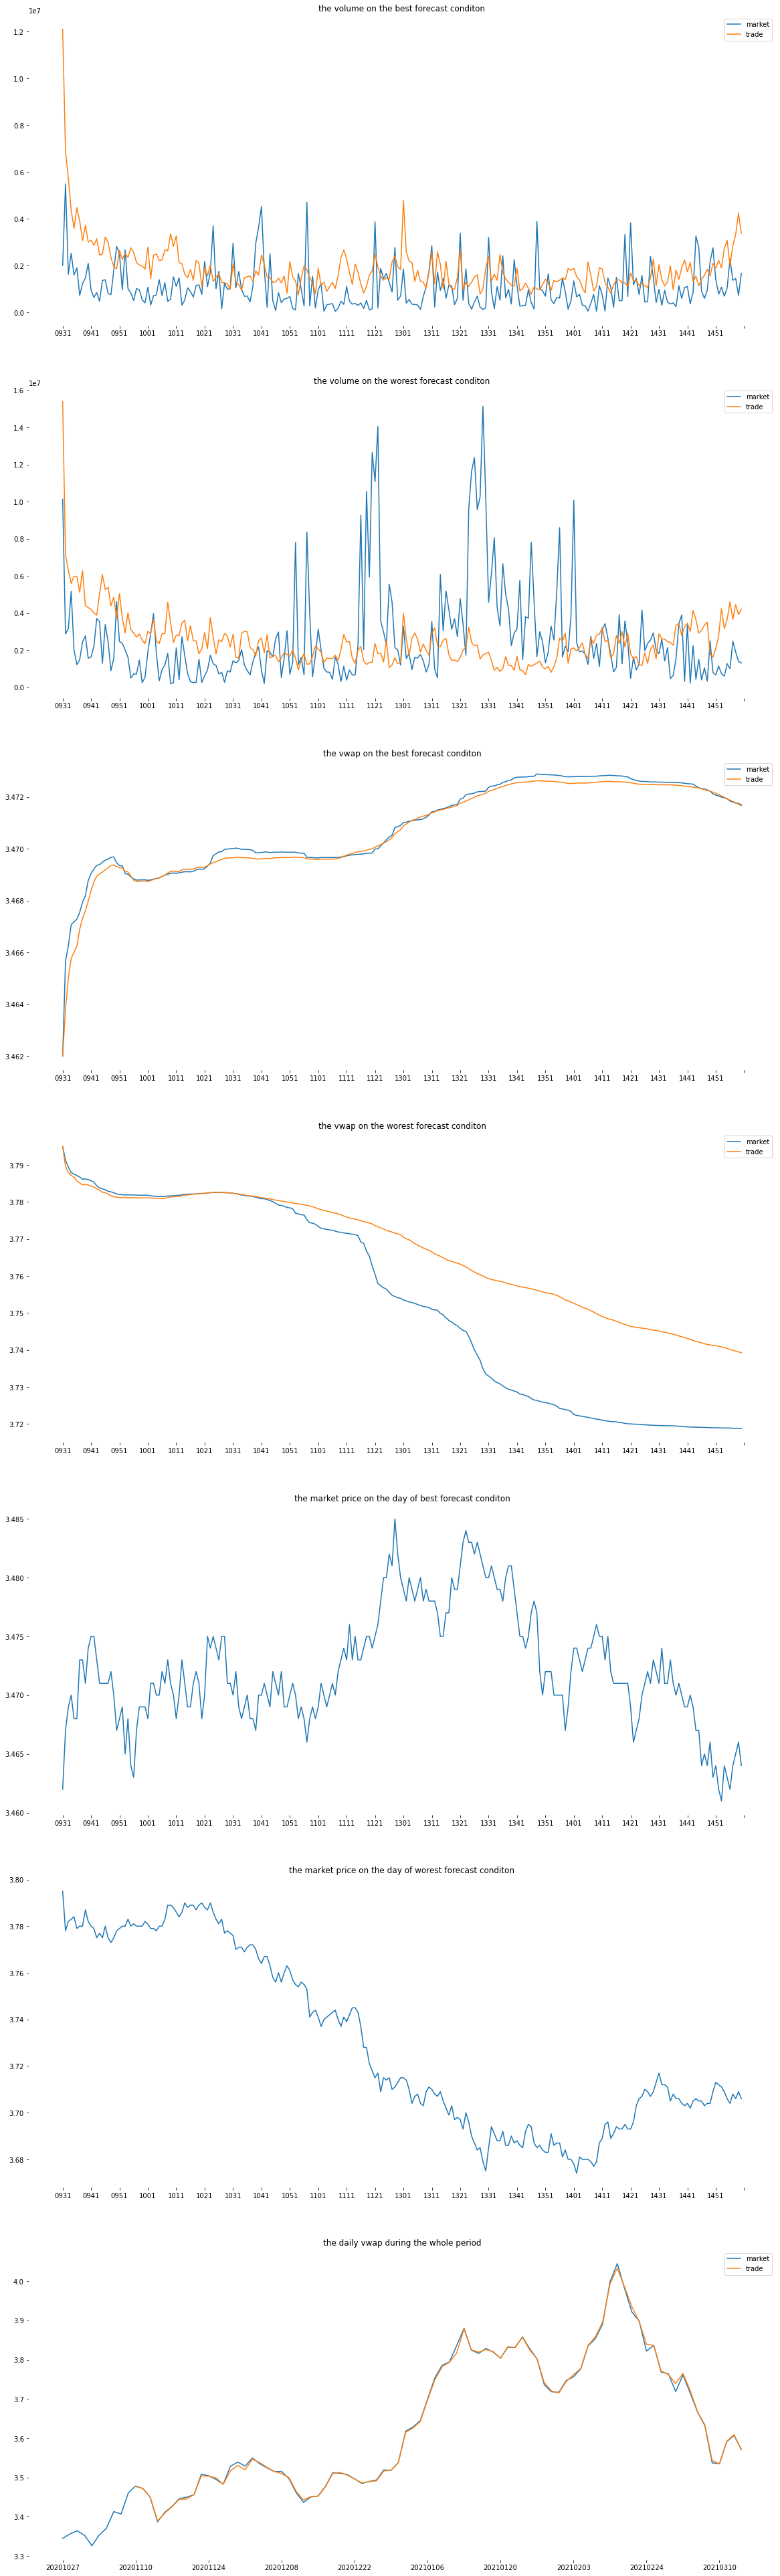

In [469]:
#交易量真实值与预测值相关情况对比

t = list_time
d = list_date

#以下所有的x相关变量表示误差最小值所在日期的情况
#以下所有的y相关的变量表示误差最大值所在日期的情况

#交易量
x1 = df_volume_m.loc['20201111',:]
x2 = df_volume_p.loc['20201111',:]
y1 = df_volume_m.loc['20210302',:]
y2 = df_volume_p.loc['20210302',:]

#VWAP
x3 = df_vwap_m.loc['20201111',:]
x4 = df_vwap_p.loc['20201111',:]
y3 = df_vwap_m.loc['20210302',:]
y4 = df_vwap_p.loc['20210302',:]

#开盘价
x5 = df_open_m.loc['20201111',:]
y5 = df_open_m.loc['20210302',:]

#研究期间内日间VWAP
z1 = df_vwap_m.iloc[:,len(list_time)-1]
z2 = df_vwap_p.iloc[:,len(list_time)-1]

#画图
plt.figure(figsize = (20,70))
my_x_ticks = np.arange(0, 250, 10)
my_x2_ticks = np.arange(0,100,10)

plt.subplot(7,1,1,frameon = False)
plt.plot(t,x1,x2)
plt.xticks(my_x_ticks)
plt.legend( ['market', 'trade'], loc = 'best')
plt.title('the volume on the best forecast conditon')

plt.subplot(7,1,2,frameon = False)
plt.plot(t,y1,y2)
plt.xticks(my_x_ticks)
plt.legend( ['market', 'trade'], loc = 'best')
plt.title('the volume on the worest forecast conditon')

plot_vwap = plt.subplot(7,1,3,frameon = False)
plt.plot(t,x3,x4)
plt.xticks(my_x_ticks)
plt.legend( ['market', 'trade'], loc = 'best')
plt.title('the vwap on the best forecast conditon')

plot_vwap = plt.subplot(7,1,4,frameon = False)
plt.plot(t,y3,y4)
plt.xticks(my_x_ticks)
plt.legend( ['market', 'trade'], loc = 'best')
plt.title('the vwap on the worest forecast conditon')

plt_open = plt.subplot(7,1,5,frameon = False)
plt.plot(t,x5)
plt.xticks(my_x_ticks)
plt.title('the market price on the day of best forecast conditon')

plt_open = plt.subplot(7,1,6,frameon = False)
plt.plot(t,y5)
plt.xticks(my_x_ticks)
plt.title('the market price on the day of worest forecast conditon')

plot_vwap_d = plt.subplot(7,1,7,frameon = False)
plt.plot(d,z1,z2)
plt.xticks(my_x2_ticks)
plt.legend( ['market', 'trade'], loc = 'best')
plt.title('the daily vwap during the whole period')

plt.show()


In [470]:
#IS模型中的迭代算法

In [471]:
#定义变量
array_x= np.full((1,239), 1/239) #每个时间区间的卖出资产的比例向量
M = 1000  #最大迭代次数
epsilon = 0.0001  #收敛阈值
epsilon_2 = 0.00001
matrix_cov = np.arange(239*239).reshape(239,239)  #协方差矩阵

In [472]:
#求算历史波动率
tmp_sigma = []

for k in range(1,31):
    tmp_sigma.append(np.std(df_open_m.iloc[location_min-k,:],ddof=1))  #这里波动率的求算以VWAP误差最小的一天的前30天的平均波动率计算

sigma = np.mean(tmp_sigma)

In [473]:
#求算协方差矩阵

for n in range(0,239):
    for m in range(0,239):
        if n>m:
            matrix_cov[n,m] = m+1
        elif n<=m:
            matrix_cov[n,m] = n+1


In [474]:
# 实行迭代算法求解资产分配比例

df_x_p = pd.DataFrame(index = list_date,columns =  list_time) 
list_beta = np.ones(239) #定义变量向量beta
list_beta_1 = 1/list_beta  #定义变量beta的倒数的向量

tmp_counter,jug_factor= 0,100

#实施算法
while  jug_factor > epsilon and tmp_counter < M :
    array_x = list_beta_1/np.sum(list_beta_1)
    list_beta = np.dot(matrix_cov,array_x.T)/ (np.dot(np.dot(array_x,matrix_cov),array_x.T) )
    list_beta_1 = 1/list_beta
        
    tmp =  0
    for i in range(239):
        tmp += np.square(array_x[i] * list_beta[i] - 1/239)
    
        jug_factor = np.sqrt(tmp/238)
        tmp_counter +=1

    #在第一位之前插入0
    array_x=np.hstack((0,array_x))

In [475]:
#简单回测步骤一

#定义变量
df_volume_m_percentage = pd.DataFrame(index = list_date,columns =  list_time)  #用以储存每个交易日各时点的市场真实交易量占当日总交易量的比值
df_volume_p_percentage = pd.DataFrame(index = list_date,columns =  list_time)  #用以储存每个交易日各时点的预测交易量占当日总交易量的比值
list_remain_is,list_remain_vwap= [1],[1]  #用以储存IS策略和VWAP策略每次交易之后的剩余持有量（以误差最小日的情况为例）

list_volume_m = df_volume_m.apply(lambda x:x.sum(),axis =1)  #储存市场日交易总量
list_volume_p = df_volume_p.apply(lambda x:x.sum(),axis = 1)   #储存预测日交易总量

#将百分比数据导入
for k in range(len(list_date)):
    for i in range(len(list_time)):
        df_volume_m_percentage.iloc[k,i] = df_volume_m.iloc[k,i] / list_volume_m[k]
        df_volume_p_percentage.iloc[k,i] = df_volume_p.iloc[k,i] / list_volume_p[k]
        

#求算当日的每个交易时点的资产剩余持有量
tmp_is, tmp_vwap = 0, 0

for i in range(len(list_time)):
    if i != 0:
        #计算IS策略
        tmp_is +=array_x[i]
        tmp1 = list_remain_is[i-1] * (1-tmp_is)
        list_remain_is.append(tmp1)
    
        #计算VWAP策略
        tmp_vwap += df_volume_p_percentage.iloc[location,i]
        tmp2 =  list_remain_vwap[i-1] * (1-tmp_vwap)
        list_remain_vwap.append(tmp2)

In [476]:
#简单回测步骤二

#定义变量
df_asset_is = pd.DataFrame(index = list_date, columns = list_time)  #用以储存IS策略的资产持有值
df_asset_vwap = pd.DataFrame(index = list_date, columns = list_time)  #用以储存VWAP策略的资产持有值


# 由于前十个交易日预测数据缺失，初始从10开始
df_asset_is.iloc[10,0] = df_open_m.iloc[10,0]  #设置IS策略资产初始值，设持有一个单位
df_asset_vwap.iloc[10,0] = df_open_m.iloc[10,0]  #设置VWAP策略资产初始值，设持有一个单位

# 不考虑交易佣金，交易按照预测的交易量执行
tmp_volume_decrease = 0 
for k in range(10,len(list_date)):
    for i in range(1,len(list_time)):
            #IS策略的交易执行
            tmp_volume_decrease = array_x[i]
            value_delta = tmp_volume_decrease * (df_open_m.iloc[k,i] - df_open_m.iloc[k-1,len(list_time)-1])
            df_asset_is.iloc[k,i] = df_asset_is.iloc[k, i-1]+value_delta                
            #VWAP策略的交易执行
            tmp_volume_decrease = df_volume_p_percentage.iloc[k,i]
            value_delta = tmp_volume_decrease * (df_open_m.iloc[k,i] -df_open_m.iloc[k-1,len(list_time)-1])
            df_asset_vwap.iloc[k,i] = df_asset_vwap.iloc[k,i-1]+value_delta
            
            #设定上一交易日结束的资产值为下一交易日开始的资产值
            if k < len(list_date)-1:
                df_asset_vwap.iloc[k+1,0] = df_asset_vwap.iloc[k,len(list_time)-1]
                df_asset_is.iloc[k+1,0] = df_asset_is.iloc[k,len(list_time)-1]

Text(0.5, 1.0, 'theasset value  backtest')

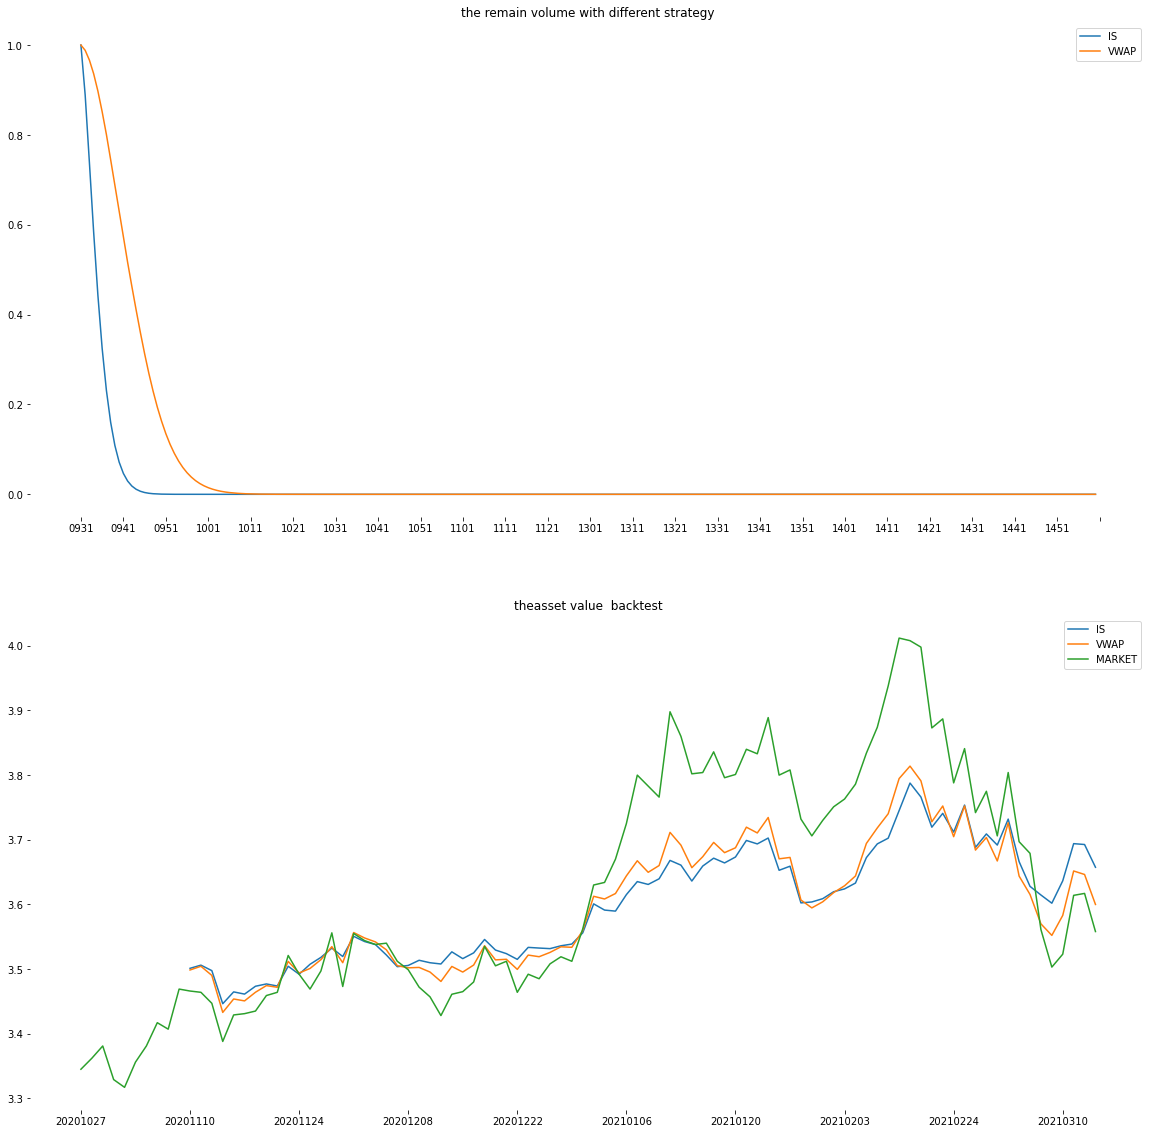

In [477]:
#简单回测步骤三
#画图
plt.figure(figsize = (20, 20))
my_x_ticks = np.arange(0, 250, 10)
my_x2_ticks = np.arange(0,100,10)

plt.subplot(2,1,1,frameon =False)
plt.plot(t,list_remain_is,list_remain_vwap)
plt.xticks(my_x_ticks)
plt.legend( ['IS', 'VWAP'], loc = 'best')
plt.title('the remain volume with different strategy')

plt.subplot(2,1,2,frameon = False)
plt.plot(d,df_asset_is.iloc[:,len(list_time)-1], df_asset_vwap.iloc[:,len(list_time)-1])
plt.plot(d,df_open_m.iloc[:,len(list_time)-1])
plt.legend( ['IS', 'VWAP','MARKET'], loc = 'best')
plt.xticks(my_x2_ticks)
plt.title('theasset value  backtest')